In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv('sorting_event_volumes_2023.csv')

df['scanning_date'] = pd.to_datetime(df['scanning_date'], errors='coerce')
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.dayofweek + 1
df['week'] = df['scanning_date'].dt.isocalendar().week
df['week_of_month'] = (df['day'] - 1) // 7 + 1
df['yearday'] = df['scanning_date'].dt.dayofyear  # Voeg de dag van het jaar toe

# Data cleaning
print("Number of rows is: " + str(df.shape[0]))
df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df['scanning_date'] = pd.to_datetime(df['scanning_date'])
print("Number of rows cleaned data is: " + str(df.shape[0]))

Number of rows is: 8949721


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_22172\1169075445.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_22172\1169075445.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_22172\1169075445.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

Number of rows cleaned data is: 7450939


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_22172\1169075445.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scanning_date'] = pd.to_datetime(df['scanning_date'])


In [ ]:
def fill_missing_events(df):
    df_filled_list = []
    
    for center in df['sorting_center_name'].unique():
        df_center = df[df['sorting_center_name'] == center]
        output_belts = df_center['output_belt'].unique()
        
        min_date = df_center['scanning_date'].min()
        max_date = df_center['scanning_date'].max()

        all_dates = pd.date_range(start=pd.Timestamp(year=min_date.year, month=1, day=1), end=pd.Timestamp(year=max_date.year, month=max_date.month, day=1) + pd.offsets.MonthEnd(0))
        
        all_combinations = pd.MultiIndex.from_product(
            [[center], all_dates, output_belts],
            names=['sorting_center_name', 'scanning_date', 'output_belt']
        )
        
        all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
        df_filled_center = pd.merge(all_combinations_df, df_center, 
                                    on=['sorting_center_name', 'scanning_date', 'output_belt'], 
                                    how='left')
        
        df_filled_center['no_of_events'] = df_filled_center['no_of_events'].fillna(0.0001)
        df_filled_list.append(df_filled_center)
    
    df_filled = pd.concat(df_filled_list, ignore_index=True)
    
    return df_filled

In [3]:
df_o = df

## Grouping and Merging Event Data by Sorting Center
The dataset is processed to group and merge event data by sorting center:

1. **Group by `scanning_date` and `output_belt`:** The data is grouped based on `scanning_date` and `output_belt` for each sorting center. The total number of events (`no_of_events`) is summed for each group.
2. **Merge with Additional Features:** The grouped data is merged with additional features such as `day`, `month`, `weekday`, `week`, `week_of_month`, and `yearday`. These features are extracted from the original dataset to retain relevant date-related information.
3. **Split by Sorting Center:** After processing, the dataset is split into individual dataframes for each sorting center (VANTAA, LIETO, TAMPERE, SEINÄJOKI, KUOPIO, OULU) for further analysis.

This process ensures that each sorting center has its own summarized dataset with date-related features intact.

In [4]:
# Library with all seperated sorting centers, summed over number of events, per day, per output belt
dfs = {name: group.groupby(['scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum()
       .merge(group[['scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month','yearday']].drop_duplicates(), 
              on='scanning_date', how='left')
       for name, group in df.groupby('sorting_center_name')}

In [5]:
dfs['VANTAA']

scanning_date  output_belt  no_of_events  day  month  weekday  week  \
0        2023-01-02            0             1    2      1        1     1   
1        2023-01-02            1           533    2      1        1     1   
2        2023-01-02            2           256    2      1        1     1   
3        2023-01-02            3          1422    2      1        1     1   
4        2023-01-02            4          1684    2      1        1     1   
...             ...          ...           ...  ...    ...      ...   ...   
44001    2023-12-30           96           956   30     12        6    52   
44002    2023-12-30           97           692   30     12        6    52   
44003    2023-12-30           98           929   30     12        6    52   
44004    2023-12-30           99            47   30     12        6    52   
44005    2023-12-30          100           540   30     12        6    52   

       week_of_month  yearday  
0                  1        2  
1                  1        2  
2                  1        2  
3                  1        2  
4                  1        2  
...              ...      ...  
44001              5      364  
44002              5      364  
44003              5      364  
44004              5      364  
44005              5      364  

[44006 rows x 9 columns]

### Code Explanation: `fill_missing_events`

The `fill_missing_events` function fills missing event data by:

1. **Creating All Date and Output Belt Combinations**: Generates all dates from the minimum to the maximum `scanning_date` and combines them with unique `output_belt` values.
2. **Merging with Original Data**: Merges these combinations with the original dataframe to add missing entries, setting `no_of_events` to `0` for missing values.
3. **Adding Date Components**: Adds columns for day, month, weekday, week, week of month, and yearday for each `scanning_date`.

Finally, it applies this function to all dataframes in `dfs`.

In [6]:
def fill_missing_events(df):
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())
    all_combinations = pd.MultiIndex.from_product([all_dates, df['output_belt'].unique()], names=['scanning_date', 'output_belt'])
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    df_filled = pd.merge(all_combinations_df, df, on=['scanning_date', 'output_belt'], how='left')
    
    # Vul missende waarden
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1
    df_filled['yearday'] = df_filled['scanning_date'].dt.dayofyear  # Voeg yearday toe zonder NaNs

    return df_filled

# Pas de functie toe op alle items in dfs
dfs = {name: fill_missing_events(df) for name, df in dfs.items()}

In [7]:
dfs['VANTAA']

scanning_date  output_belt  no_of_events  day  month  weekday  week  \
0        2023-01-02            0           1.0    2      1        1     1   
1        2023-01-02            1         533.0    2      1        1     1   
2        2023-01-02            2         256.0    2      1        1     1   
3        2023-01-02            3        1422.0    2      1        1     1   
4        2023-01-02            4        1684.0    2      1        1     1   
...             ...          ...           ...  ...    ...      ...   ...   
54445    2023-12-30          315           0.0   30     12        6    52   
54446    2023-12-30          316           0.0   30     12        6    52   
54447    2023-12-30          302           0.0   30     12        6    52   
54448    2023-12-30           99          47.0   30     12        6    52   
54449    2023-12-30          304           0.0   30     12        6    52   

       week_of_month  yearday  
0                  1        2  
1                  1        2  
2                  1        2  
3                  1        2  
4                  1        2  
...              ...      ...  
54445              5      364  
54446              5      364  
54447              5      364  
54448              5      364  
54449              5      364  

[54450 rows x 9 columns]

In [8]:
### Extra features and one hot encoding of the output belt

In [9]:
for name, df in dfs.items():
    df['mult'] = df['day'] * df['weekday'] * df['week_of_month']
    df['sum'] = df['day'] + df['weekday'] + df['week_of_month']
    
    # Maak one-hot encoded kolommen zonder de originele 'output_belt' kolom te verwijderen
    one_hot_belt = pd.get_dummies(df['output_belt'], prefix='output_belt').astype(int)
    df = pd.concat([df, one_hot_belt], axis=1)
    
    # Update de DataFrame in de dictionary
    dfs[name] = df

# Controleer het resultaat voor 'VANTAA'
dfs['VANTAA']


scanning_date  output_belt  no_of_events  day  month  weekday  week  \
0        2023-01-02            0           1.0    2      1        1     1   
1        2023-01-02            1         533.0    2      1        1     1   
2        2023-01-02            2         256.0    2      1        1     1   
3        2023-01-02            3        1422.0    2      1        1     1   
4        2023-01-02            4        1684.0    2      1        1     1   
...             ...          ...           ...  ...    ...      ...   ...   
54445    2023-12-30          315           0.0   30     12        6    52   
54446    2023-12-30          316           0.0   30     12        6    52   
54447    2023-12-30          302           0.0   30     12        6    52   
54448    2023-12-30           99          47.0   30     12        6    52   
54449    2023-12-30          304           0.0   30     12        6    52   

       week_of_month  yearday  mult  ...  output_belt_342  output_belt_343  \
0                  1        2     2  ...                0                0   
1                  1        2     2  ...                0                0   
2                  1        2     2  ...                0                0   
3                  1        2     2  ...                0                0   
4                  1        2     2  ...                0                0   
...              ...      ...   ...  ...              ...              ...   
54445              5      364   900  ...                0                0   
54446              5      364   900  ...                0                0   
54447              5      364   900  ...                0                0   
54448              5      364   900  ...                0                0   
54449              5      364   900  ...                0                0   

       output_belt_344  output_belt_345  output_belt_346  output_belt_347  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    0                0                0                0   
...                ...              ...              ...              ...   
54445                0                0                0                0   
54446                0                0                0                0   
54447                0                0                0                0   
54448                0                0                0                0   
54449                0                0                0                0   

       output_belt_348  output_belt_349  output_belt_350  output_belt_351  
0                    0                0                0                0  
1                    0                0                0                0  
2                    0                0                0                0  
3                    0                0                0                0  
4                    0                0                0                0  
...                ...              ...              ...              ...  
54445                0                0                0                0  
54446                0                0                0                0  
54447                0                0                0                0  
54448                0                0                0                0  
54449                0                0                0                0  

[54450 rows x 161 columns]

### Code Explanation: `EventDataset` and `create_dataloaders_for_df`

This code defines a PyTorch dataset and functions to split data and create data loaders.

1. **`EventDataset` Class**:
   - Initializes by loading data from a dataframe (`df`).
   - Stores input features (`output_belt`, `day`, `weekday`, `week_of_month`, `mult`) as integer tensors and `no_of_events` as the target.
   - `__getitem__` returns input data, targets, `output_belt`, and `yearday` for each index.
   - `__len__` gives the dataset length.

2. **`create_dataloaders_for_df` Function**:
   - Splits `df` into training and testing sets using `split_dataset`.
   - Creates and returns data loaders with specified `batch_size`.

3. **`split_dataset` Function**:
   - Splits `df` based on `method` (`random` or `sequential`) and `test_size` ratio.

In [12]:
class EventDataset(Dataset):
    def __init__(self, df):

        self.data = df  
        one_hot_columns = [col for col in self.data.columns if col.startswith('output_belt_')]
        feature_columns = one_hot_columns + ['day', 'weekday', 'week_of_month', 'mult']
        self.inputs = torch.tensor(self.data[feature_columns].values.astype(int), dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

def create_dataloaders_for_df(df, test_size=0.25, batch_size=128, method='sequential'):
    train_df, test_df = split_dataset(df, method=method, test_size=test_size)
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def split_dataset(df, method='sequential', test_size=0.25):
    if method == 'random':
        return train_test_split(df, test_size=test_size, random_state=42)
    else:  # 'sequential'
        split_idx = int((1 - test_size) * len(df))
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        return train_df, test_df

In [13]:
# Dictionary for the dataloaders
loaders = {}

for name, df in dfs.items():
    train_loader, test_loader = create_dataloaders_for_df(df)
    loaders[name] = {
        'train_loader': train_loader,
        'test_loader': test_loader
    }

### Code Explanation: `SimpleNN` Neural Network

The `SimpleNN` class defines a neural network with multiple fully connected layers and a custom activation function (`swish`). Here’s a breakdown of its structure:

1. **Network Architecture**:
   - `fc1` to `fc6`: Six fully connected layers with varying output dimensions.
   - Skip connections are implemented in the `forward` method for `fc2` and `fc4`, allowing information from earlier layers to be added directly to later ones, which helps retain important features and reduces the risk of gradient vanishing.

2. **Swish Activation Function**:
   - `swish`: A custom activation function, defined as `x * sigmoid(x)`, is used to introduce non-linearity. Swish often outperforms ReLU by allowing small negative values, which can improve model performance.

3. **Forward Pass**:
   - The input passes through each layer with the Swish activation applied.
   - After `fc1`, `fc2` and `fc4` layers use skip connections, enhancing learning by preserving important features.
   - Finally, `fc6` outputs a single value (presumably for regression).

Overall, this structure with Swish activation and skip connections is designed to improve learning efficiency and capture complex patterns in the data.

In [14]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*128)
        self.fc2 = nn.Linear(2*128, 2*128)
        self.fc3 = nn.Linear(2*128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        x1 = self.swish(self.fc1(x))
        x2 = self.swish(self.fc2(x1)) + x1  # Skip connection
        x3 = self.swish(self.fc3(x2))
        x4 = self.swish(self.fc4(x3)) + x3  # Skip connection
        x5 = self.swish(self.fc5(x4))
        output = self.fc6(x5)
        return output

# Code Explanation

## Import and Setup
1. **`trained_models = {}`**  
   Initializes an empty dictionary to store trained models, each identified by the dataset or data-loader name.

2. **`plot_losses()` function**  
   Plots training and test losses (`train_losses` and `test_losses`) over epochs, displaying loss values on the y-axis and epochs on the x-axis. This provides a visual for tracking model performance and comparing training versus test loss.

## Quantile Loss Class
3. **`QuantileLoss(nn.Module)`**  
   A custom loss class implementing quantile loss, useful for regression tasks targeting quantiles. The forward function calculates errors as the difference between `targets` and `outputs`, then applies the quantile loss formula using `torch.max`.

   - **Parameter**: `tau`, representing the quantile to compute (e.g., 0.5 for median).
   - **`criterion`**: An instance of `QuantileLoss` with `tau = 0.7`, used as the loss function during training.

## Model Training Function
4. **`train_model()` function**  
   This function trains and evaluates a model with early stopping and specified criterion and optimizer. Key components:

   - **Training**: Runs in training mode (`model.train()`). For each batch in `train_loader`, it calculates predictions, computes loss, and updates model parameters. The average training loss per epoch is stored in `train_losses`.

   - **Evaluation**: In evaluation mode (`model.eval()`), calculates total loss, mean squared error (MSE), and mean absolute error (MAE) over the test set and stores these values.

   - **Early Stopping**: Stops training if the model’s test set performance stagnates. If test loss doesn’t improve by `min_delta` over the last `patience` epochs, early stopping is triggered.

5. **Print Progress**: Prints each epoch’s training and test losses, MSE, MAE, and learning rate for feedback.

## Training Loop for Multiple Loaders
6. **Main Training Loop**  
   Iterates over each loader in `loaders`. For each loader:

   - **Model Initialization**: Sets input dimension (`input_dim`) from the data, initializes `SimpleNN`, and moves it to the specified device.

   - **Optimizer**: Sets up an Adam optimizer with a learning rate of 0.0003.

   - **Model Training**: Calls `train_model()` with the model, data loaders, criterion, optimizer, and other hyperparameters. Returns training and test losses for plotting.

   - **Store Model**: Saves the trained model in `trained_models` using the loader name as the key.

## Key Parameters
- **`tau`**: Quantile for Quantile Loss.
- **`patience` and `min_delta`**: Early stopping parameters to control tolerance for test loss improvement.
- **`train_loader` and `test_loader`**: Data loaders that provide training and testing data batches.


Training model for KUOPIO
Epoch [1/100], Train Loss: 84.0821, Test Loss: 69.5501, MSE: 37669.0626, MAE: 146.9736, LR: 0.000300
Epoch [2/100], Train Loss: 59.4745, Test Loss: 62.7754, MSE: 33837.8185, MAE: 131.5017, LR: 0.000300
Epoch [3/100], Train Loss: 53.1053, Test Loss: 55.7650, MSE: 30249.5988, MAE: 121.3003, LR: 0.000300
Epoch [4/100], Train Loss: 47.5859, Test Loss: 48.8648, MSE: 24716.3908, MAE: 106.8441, LR: 0.000300
Epoch [5/100], Train Loss: 40.7350, Test Loss: 41.6846, MSE: 20141.4678, MAE: 98.8198, LR: 0.000300
Epoch [6/100], Train Loss: 34.3856, Test Loss: 35.8201, MSE: 15251.6723, MAE: 78.0113, LR: 0.000300
Epoch [7/100], Train Loss: 28.7873, Test Loss: 32.6765, MSE: 13924.5727, MAE: 71.8754, LR: 0.000300
Epoch [8/100], Train Loss: 27.1529, Test Loss: 35.3845, MSE: 12998.7497, MAE: 67.8119, LR: 0.000300
Epoch [9/100], Train Loss: 25.2656, Test Loss: 30.2806, MSE: 13171.7614, MAE: 69.5999, LR: 0.000300
Epoch [10/100], Train Loss: 24.3345, Test Loss: 33.2053, MSE: 11629.74

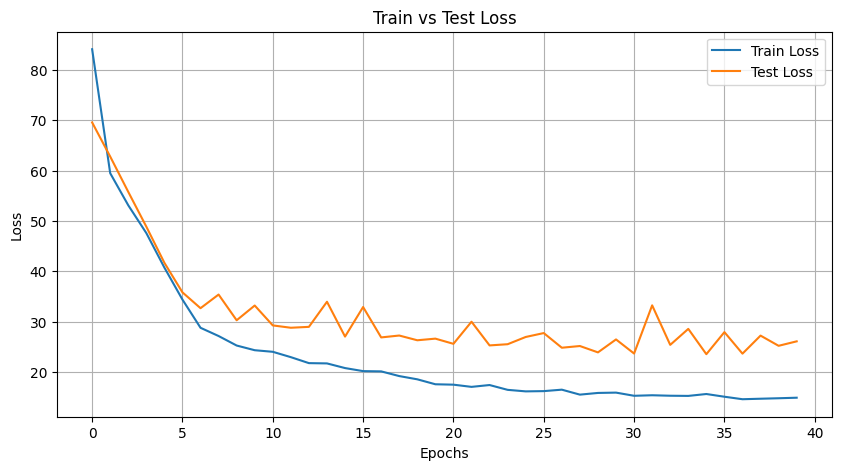

Training model for LIETO
Epoch [1/100], Train Loss: 139.4006, Test Loss: 113.5897, MSE: 96009.4173, MAE: 237.2619, LR: 0.000300
Epoch [2/100], Train Loss: 93.1718, Test Loss: 101.4246, MSE: 86253.9870, MAE: 228.3720, LR: 0.000300
Epoch [3/100], Train Loss: 83.1850, Test Loss: 92.7406, MSE: 82425.2997, MAE: 220.7413, LR: 0.000300
Epoch [4/100], Train Loss: 73.5148, Test Loss: 81.8502, MSE: 64439.1747, MAE: 185.1437, LR: 0.000300
Epoch [5/100], Train Loss: 61.0716, Test Loss: 68.2219, MSE: 49654.5932, MAE: 154.2432, LR: 0.000300
Epoch [6/100], Train Loss: 47.8545, Test Loss: 60.4560, MSE: 40709.2554, MAE: 124.3815, LR: 0.000300
Epoch [7/100], Train Loss: 42.2024, Test Loss: 56.5524, MSE: 38541.1429, MAE: 119.8732, LR: 0.000300
Epoch [8/100], Train Loss: 39.3118, Test Loss: 55.9864, MSE: 41592.6604, MAE: 136.7329, LR: 0.000300
Epoch [9/100], Train Loss: 37.8695, Test Loss: 55.5650, MSE: 36141.1295, MAE: 114.8437, LR: 0.000300
Epoch [10/100], Train Loss: 36.8218, Test Loss: 52.7711, MSE: 3

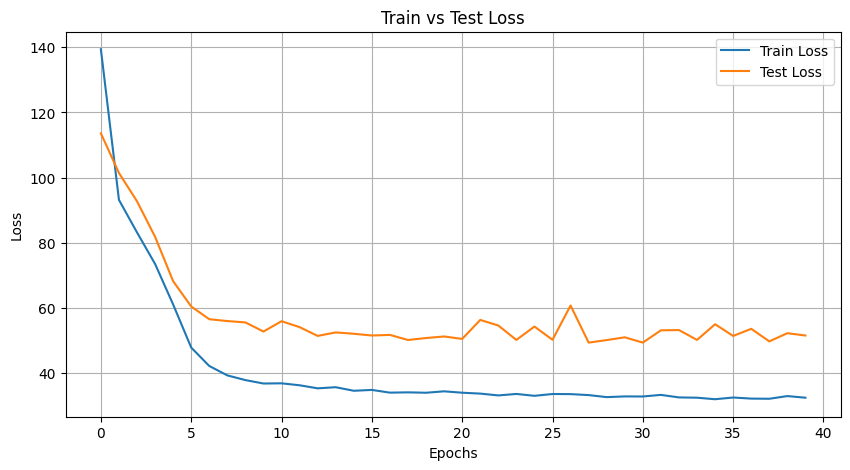

Training model for OULU
Epoch [1/100], Train Loss: 84.4997, Test Loss: 85.5474, MSE: 54126.0529, MAE: 167.5571, LR: 0.000300
Epoch [2/100], Train Loss: 62.3476, Test Loss: 78.4813, MSE: 51495.3585, MAE: 163.6388, LR: 0.000300
Epoch [3/100], Train Loss: 55.2133, Test Loss: 77.2935, MSE: 49075.7382, MAE: 150.0851, LR: 0.000300
Epoch [4/100], Train Loss: 49.0349, Test Loss: 63.9429, MSE: 38728.3748, MAE: 130.6205, LR: 0.000300
Epoch [5/100], Train Loss: 38.2922, Test Loss: 46.9989, MSE: 26662.8329, MAE: 102.5338, LR: 0.000300
Epoch [6/100], Train Loss: 28.9608, Test Loss: 44.2522, MSE: 22784.5910, MAE: 87.4085, LR: 0.000300
Epoch [7/100], Train Loss: 25.7727, Test Loss: 40.1659, MSE: 24404.2808, MAE: 96.4865, LR: 0.000300
Epoch [8/100], Train Loss: 24.5414, Test Loss: 39.8170, MSE: 20912.9585, MAE: 83.7715, LR: 0.000300
Epoch [9/100], Train Loss: 23.3732, Test Loss: 39.3785, MSE: 20131.4105, MAE: 78.6613, LR: 0.000300
Epoch [10/100], Train Loss: 22.6078, Test Loss: 38.2769, MSE: 19666.669

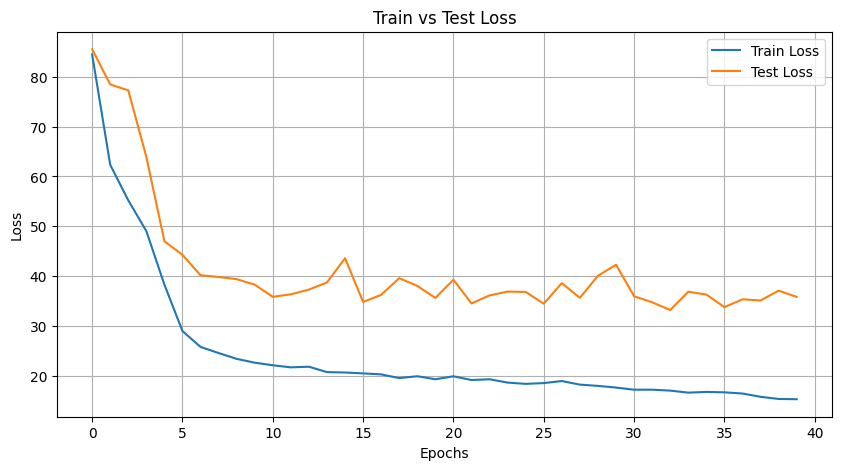

Training model for SEINÄJOKI
Epoch [1/100], Train Loss: 272.0984, Test Loss: 286.2310, MSE: 429288.0312, MAE: 523.2741, LR: 0.000300
Epoch [2/100], Train Loss: 237.0355, Test Loss: 252.8004, MSE: 306335.0849, MAE: 449.2611, LR: 0.000300
Epoch [3/100], Train Loss: 170.3904, Test Loss: 171.8241, MSE: 198034.4226, MAE: 366.5938, LR: 0.000300
Epoch [4/100], Train Loss: 135.5596, Test Loss: 157.7648, MSE: 163664.2663, MAE: 324.4286, LR: 0.000300
Epoch [5/100], Train Loss: 125.9940, Test Loss: 147.6989, MSE: 163635.0598, MAE: 327.1387, LR: 0.000300
Epoch [6/100], Train Loss: 120.1777, Test Loss: 148.8517, MSE: 146496.1328, MAE: 302.3465, LR: 0.000300
Epoch [7/100], Train Loss: 118.7325, Test Loss: 141.8909, MSE: 143303.3753, MAE: 298.1333, LR: 0.000300
Epoch [8/100], Train Loss: 113.4968, Test Loss: 143.7868, MSE: 137545.5717, MAE: 289.6809, LR: 0.000300
Epoch [9/100], Train Loss: 108.8669, Test Loss: 132.8114, MSE: 162477.2955, MAE: 326.7635, LR: 0.000300
Epoch [10/100], Train Loss: 107.022

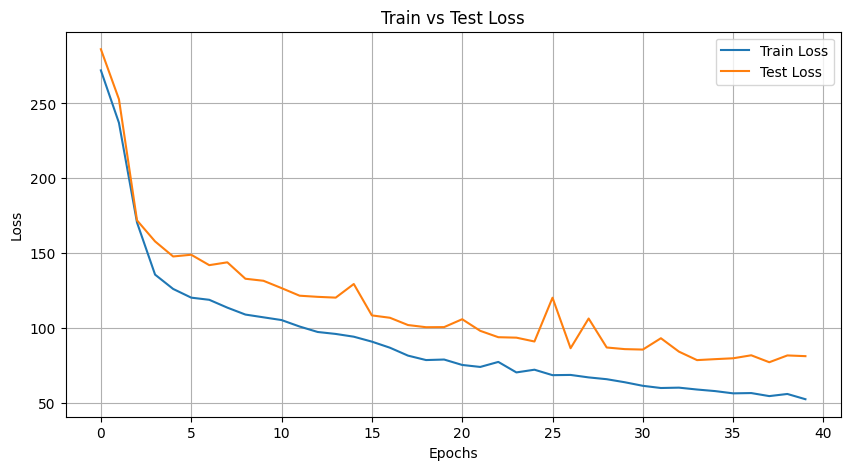

Training model for TAMPERE
Epoch [1/100], Train Loss: 104.1926, Test Loss: 98.9408, MSE: 82933.1587, MAE: 192.4677, LR: 0.000300
Epoch [2/100], Train Loss: 73.9713, Test Loss: 83.8772, MSE: 73563.7039, MAE: 173.8414, LR: 0.000300
Epoch [3/100], Train Loss: 63.5936, Test Loss: 75.6580, MSE: 58574.6410, MAE: 142.8443, LR: 0.000300
Epoch [4/100], Train Loss: 46.9631, Test Loss: 52.1863, MSE: 41057.0013, MAE: 109.4703, LR: 0.000300
Epoch [5/100], Train Loss: 38.0033, Test Loss: 48.5221, MSE: 36570.9319, MAE: 96.8218, LR: 0.000300
Epoch [6/100], Train Loss: 34.9208, Test Loss: 54.9034, MSE: 36202.0802, MAE: 95.5023, LR: 0.000300
Epoch [7/100], Train Loss: 33.7977, Test Loss: 52.1413, MSE: 34064.2984, MAE: 91.3784, LR: 0.000300
Epoch [8/100], Train Loss: 32.1707, Test Loss: 49.2655, MSE: 31456.5240, MAE: 88.4727, LR: 0.000300
Epoch [9/100], Train Loss: 31.2306, Test Loss: 56.8400, MSE: 33002.5896, MAE: 94.4862, LR: 0.000300
Epoch [10/100], Train Loss: 29.9443, Test Loss: 41.7772, MSE: 26358.

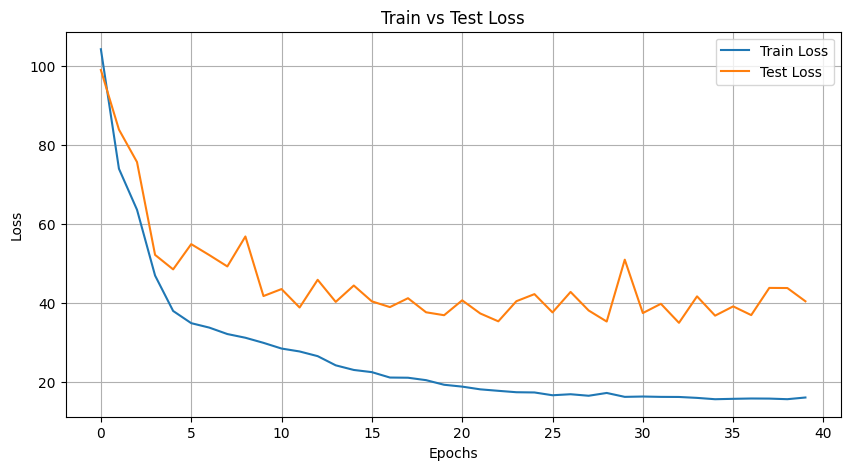

Training model for VANTAA
Epoch [1/100], Train Loss: 411.8796, Test Loss: 401.1510, MSE: 1863317.8202, MAE: 722.6288, LR: 0.000300
Epoch [2/100], Train Loss: 297.4693, Test Loss: 364.0860, MSE: 1734198.5024, MAE: 678.2250, LR: 0.000300
Epoch [3/100], Train Loss: 266.7215, Test Loss: 308.4089, MSE: 1567908.3129, MAE: 640.1051, LR: 0.000300
Epoch [4/100], Train Loss: 217.0705, Test Loss: 265.4784, MSE: 1415523.1839, MAE: 626.0973, LR: 0.000300
Epoch [5/100], Train Loss: 167.6502, Test Loss: 214.4659, MSE: 1165841.2112, MAE: 411.6742, LR: 0.000300
Epoch [6/100], Train Loss: 146.9994, Test Loss: 227.6429, MSE: 1139662.9183, MAE: 392.7162, LR: 0.000300
Epoch [7/100], Train Loss: 139.1103, Test Loss: 196.6744, MSE: 1086354.1522, MAE: 431.2959, LR: 0.000300
Epoch [8/100], Train Loss: 141.3626, Test Loss: 198.5007, MSE: 1081059.5484, MAE: 463.5583, LR: 0.000300
Epoch [9/100], Train Loss: 132.3381, Test Loss: 224.3592, MSE: 1040696.8505, MAE: 378.8492, LR: 0.000300
Epoch [10/100], Train Loss: 1

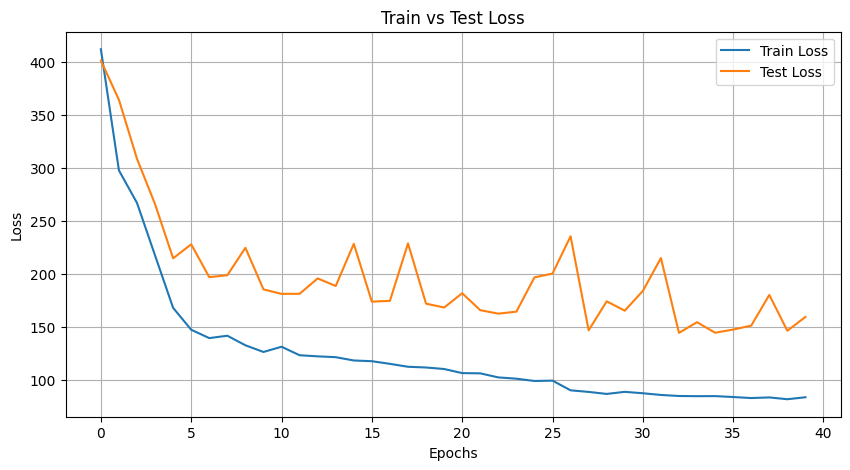

In [15]:
trained_models = {}
# criterion = nn.L1Loss()

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

class QuantileLoss(nn.Module):
    def __init__(self, tau):
        super(QuantileLoss, self).__init__()
        self.tau = tau
    
    def forward(self, outputs, targets):
        errors = targets - outputs
        loss = torch.max(self.tau * errors, (self.tau - 1) * errors)
        return loss.mean()
tau = 0.7  # Kies een waarde voor tau (0.5 is de mediaan)
criterion = QuantileLoss(tau=tau)

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=20, min_delta=0.1):
    train_losses, test_losses = [], []
    early_stopping_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _, _ in train_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_loss = 0.0
        total_mse = 0.0
        total_mae = 0.0
        with torch.no_grad():
            for inputs, targets, _, _ in test_loader:
                inputs, targets = inputs.float().to(device), targets.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                mse = nn.MSELoss()(outputs, targets)
                mae = nn.L1Loss()(outputs, targets)
                total_loss += loss.item()
                total_mse += mse.item()
                total_mae += mae.item()
        avg_test_loss = total_loss / len(test_loader)
        avg_test_mse = total_mse / len(test_loader)
        avg_test_mae = total_mae / len(test_loader)
        test_losses.append(avg_test_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
              f'MSE: {avg_test_mse:.4f}, MAE: {avg_test_mae:.4f}, LR: {current_lr:.6f}')
        
        # Early stopping op basis van de agressievere criteria
        if epoch >= patience:
            if avg_test_loss > min(test_losses[-patience:]) - min_delta:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0    
            if early_stopping_counter >= patience:
                print(f'Early stopping na {epoch + 1} epochs.')
                break

    return train_losses, test_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for name, loader_dict in loaders.items():
    input_dim = next(iter(loader_dict['train_loader']))[0].shape[1]
    model = SimpleNN(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    
    print(f'Training model for {name}')
    train_losses, test_losses = train_model(
        model,
        loader_dict['train_loader'],
        loader_dict['test_loader'],
        criterion,
        optimizer,
        epochs=100,
        patience=20,
        min_delta=0.1
    )
    
    plot_losses(train_losses, test_losses)
    
    trained_models[name] = model


# Code Explanation

## Plotting Output Belts for a Center
1. **`plot_output_belts_for_center()` function**  
   This function plots predictions (`Outputs`), targets (`Targets`), and their differences for specific output belts at a sorting center:
   - **Data Collection**: Loops through the `test_loader`, collecting `outputs`, `targets`, `output_belts`, and `yearday`.
   - **Plotting Belts**: For each belt, sorts data by `yearday` and plots `Targets`, `Outputs`, and `Difference`. If no data exists for a belt, it prints a message.

## Plotting for All Centers
2. **`plot_for_all_centers()` function**  
   Plots results for all centers or specific ones, with options for specific belts:
   - **Filtering by Center and Belts**: If `specific_center` or `specific_belt` is set, it only processes the selected ones; otherwise, it selects random belts.
   - **Plot Generation**: Calls `plot_output_belts_for_center()` to generate plots for each selected belt in each center.

## Belt Specification per Center
3. **`belts_per_center`**  
   Collects unique belts for each center using the `test_loader`, storing them in `belts_per_center` for flexible belt selection during plotting.


In [17]:
def plot_output_belts_for_center(model, test_loader, sorting_center_name, belts):
    all_outputs, all_targets, all_output_belts, all_yeardays = [], [], [], []

    for inputs, targets, output_belts, yearday in test_loader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        all_outputs.append(model(inputs).squeeze().cpu().detach().numpy())
        all_targets.append(targets.cpu().numpy())
        all_output_belts.append(output_belts.cpu().numpy())
        all_yeardays.append(yearday.cpu().numpy())

    all_outputs, all_targets, all_output_belts, all_yeardays = map(np.concatenate, 
                                                                   (all_outputs, all_targets, all_output_belts, all_yeardays))

    for belt in belts:
        mask = all_output_belts == belt
        if mask.any():
            sort_idx = np.argsort(all_yeardays[mask])
            plt.figure(figsize=(15, 5))
            plt.plot(all_yeardays[mask][sort_idx], all_targets[mask][sort_idx], label='Targets', alpha=0.7)
            plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx], label='Outputs', alpha=0.7)
            plt.plot(all_yeardays[mask][sort_idx], all_outputs[mask][sort_idx] - all_targets[mask][sort_idx], 
                     label='Difference', linestyle='--', alpha=0.7)
            plt.xlabel('Yearday')
            plt.ylabel('Waarde')
            plt.title(f'Sorting Center: {sorting_center_name}, Output Belt {belt}')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"No data found for Output Belt {belt} in {sorting_center_name}")

def plot_for_all_centers(models, loaders, belts_per_center, specific_center=None, specific_belt=None, random_belts_count=5):
    for name, model in models.items():
        if specific_center and name != specific_center:
            continue  # Sla andere centers over als een specifiek center is opgegeven

        print(f"Plotting for Sorting Center: {name}")
        test_loader = loaders[name]['test_loader']
        
        # Controleer welke belts aanwezig zijn in de test_loader
        available_belts = set()
        for _, _, output_belts, _ in test_loader:
            available_belts.update(output_belts.cpu().numpy())
        # print(f"Available belts in {name}: {sorted(available_belts)}")
        
        # Kies specifieke belt, anders willekeurige selectie
        if specific_belt:
            if specific_belt in available_belts:
                belts = [specific_belt]
            else:
                print(f"Specific belt {specific_belt} not found in {name}. Available belts are: {sorted(available_belts)}")
                continue
        else:
            belts = belts_per_center.get(name, [])
            if len(belts) > random_belts_count:
                belts = np.random.choice(belts, size=random_belts_count, replace=False)

        if len(belts) > 0:
            plot_output_belts_for_center(model, test_loader, name, belts)
        else:
            print(f"No belts defined for sorting center: {name}")

# Specificeer de belts voor elk center
belts_per_center = {}

for name in loaders:
    unique_belts = np.unique([belt for _, _, belts, _ in loaders[name]['test_loader'] for belt in belts.numpy()])
    belts_per_center[name] = unique_belts  # Bewaar alle unieke belts per center




Plotting for Sorting Center: KUOPIO


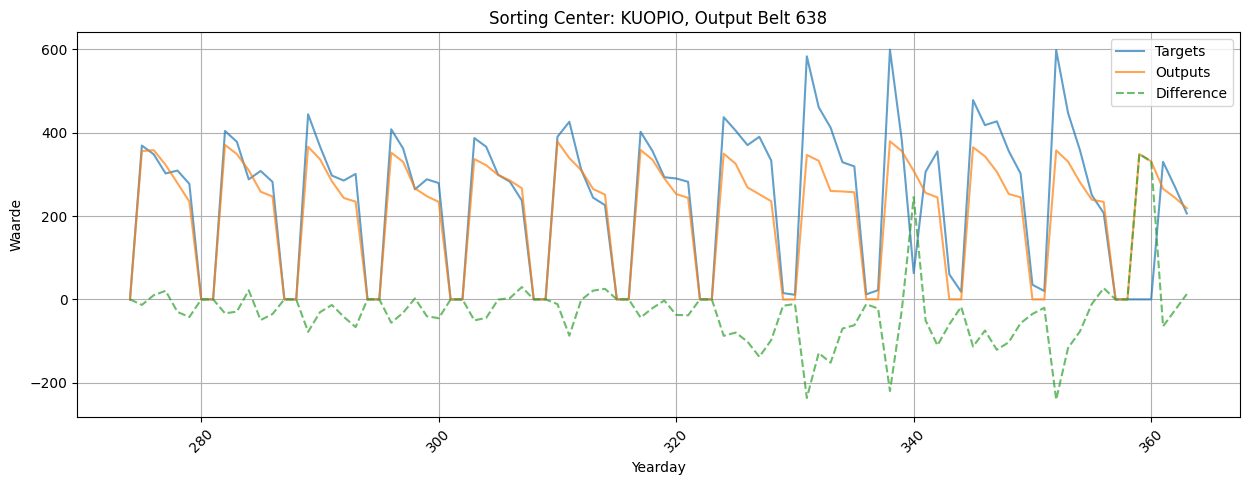

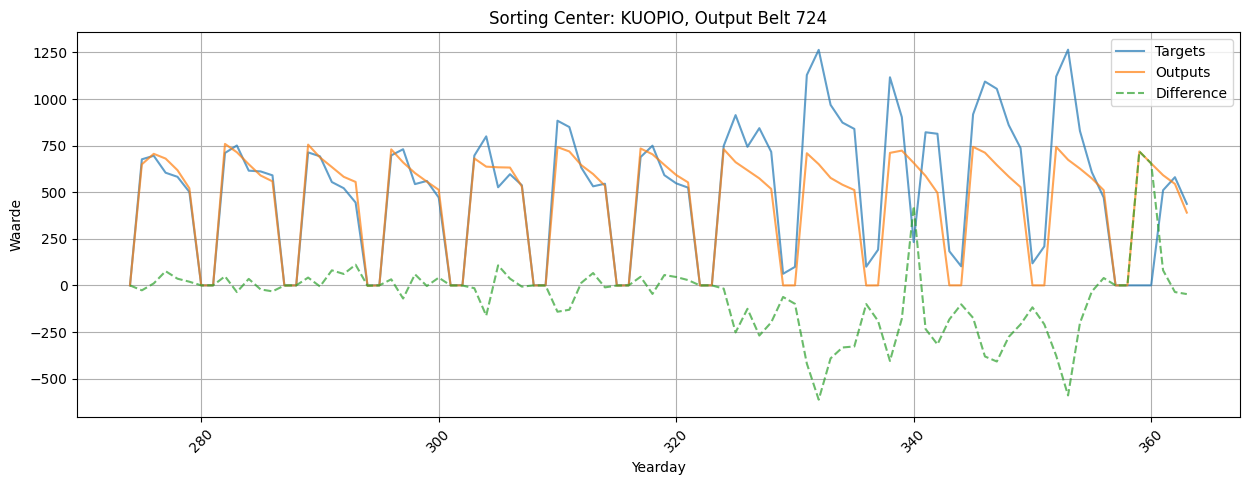

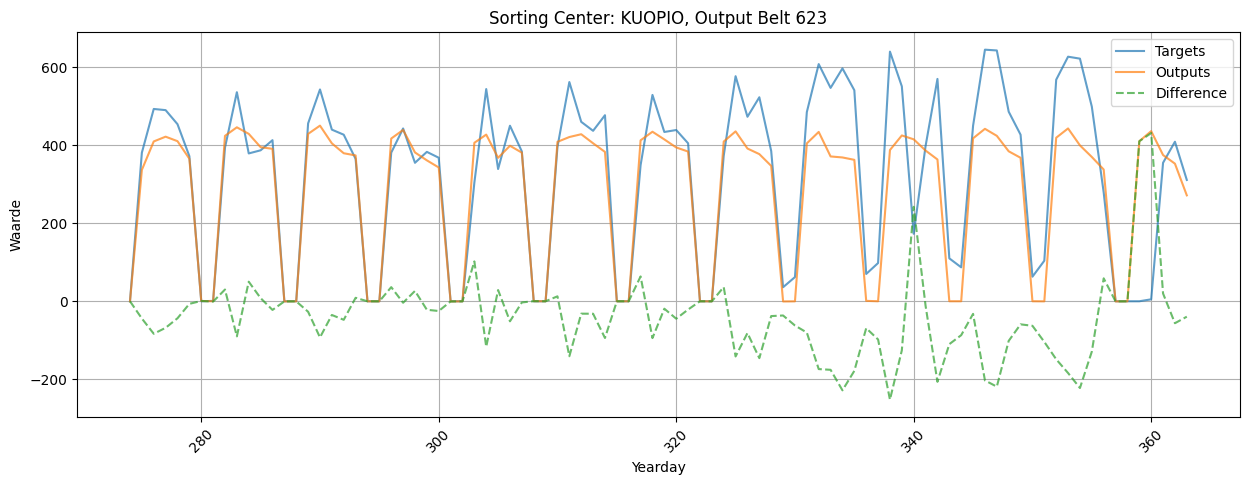

Plotting for Sorting Center: LIETO


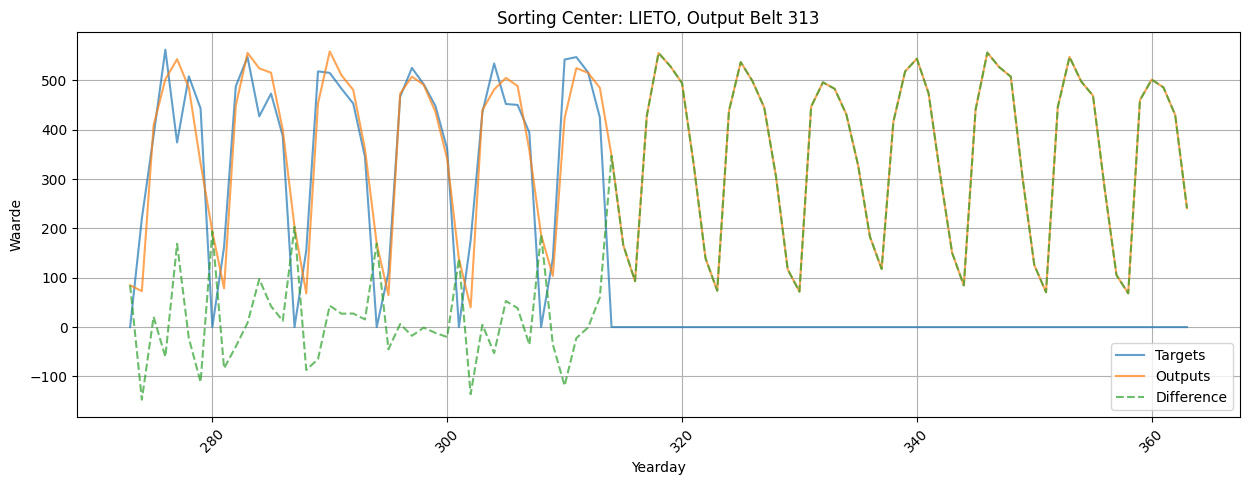

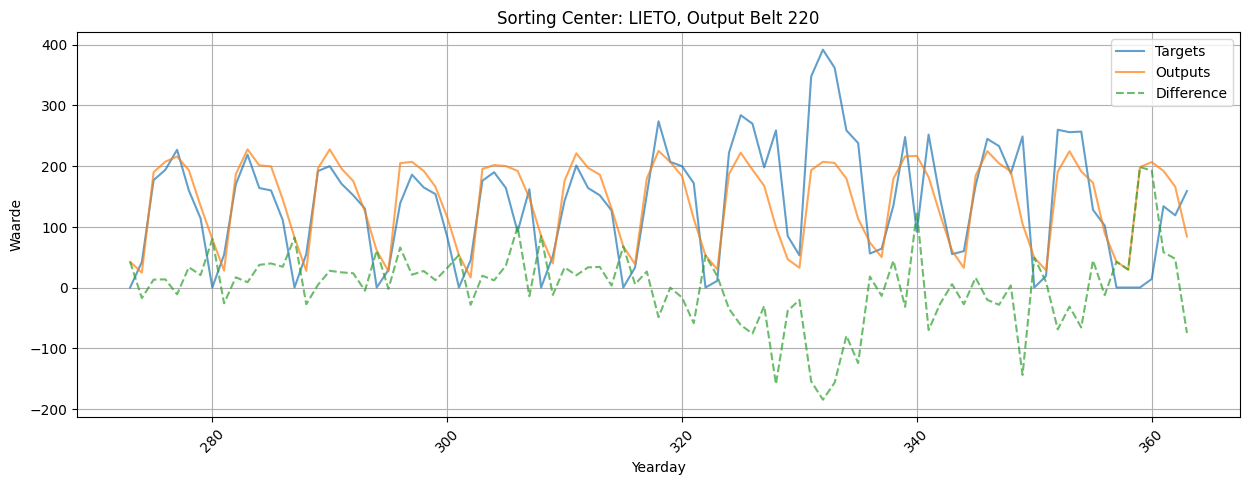

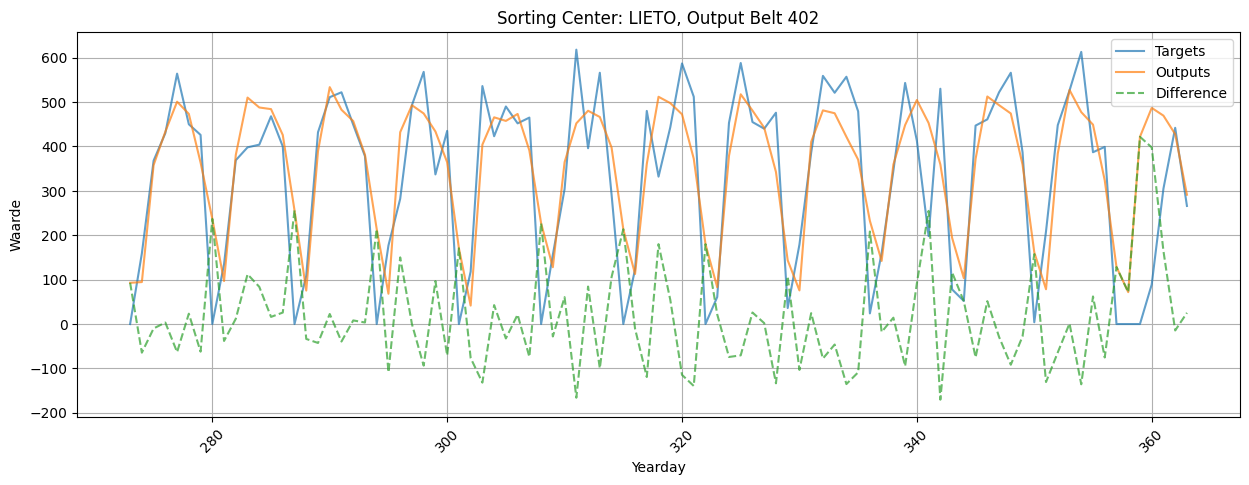

Plotting for Sorting Center: OULU


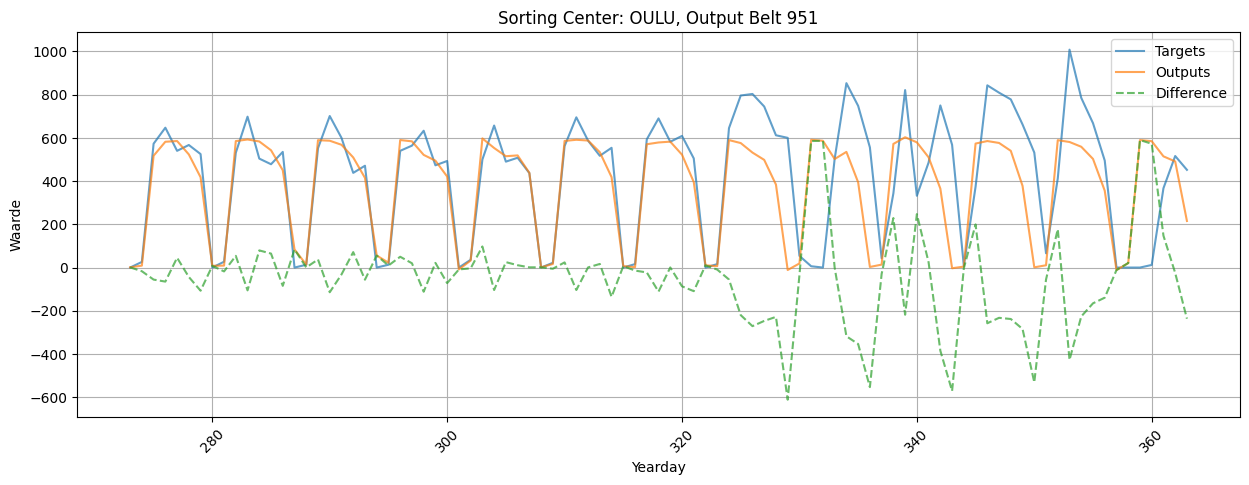

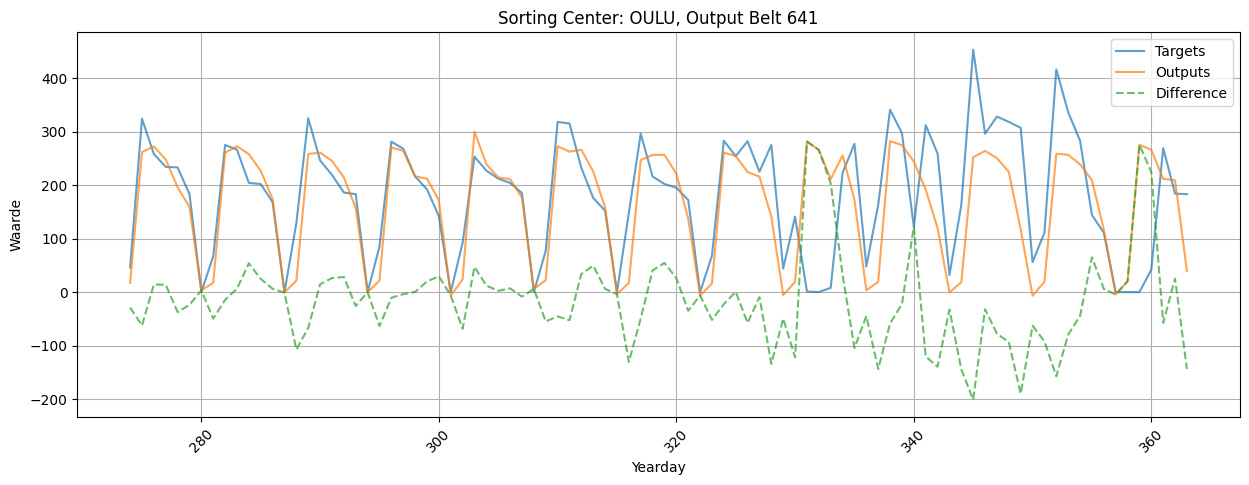

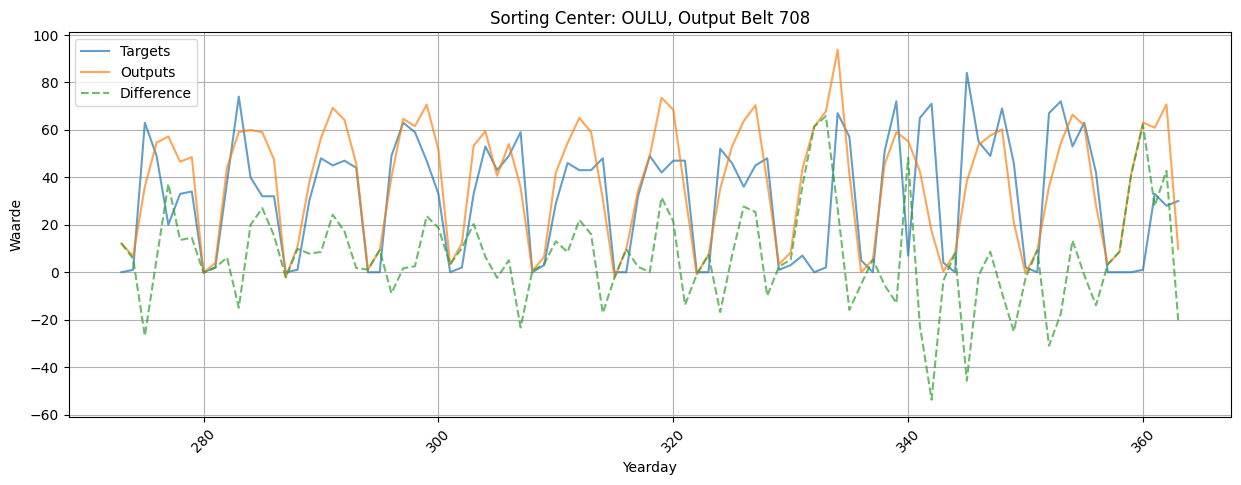

Plotting for Sorting Center: SEINÄJOKI


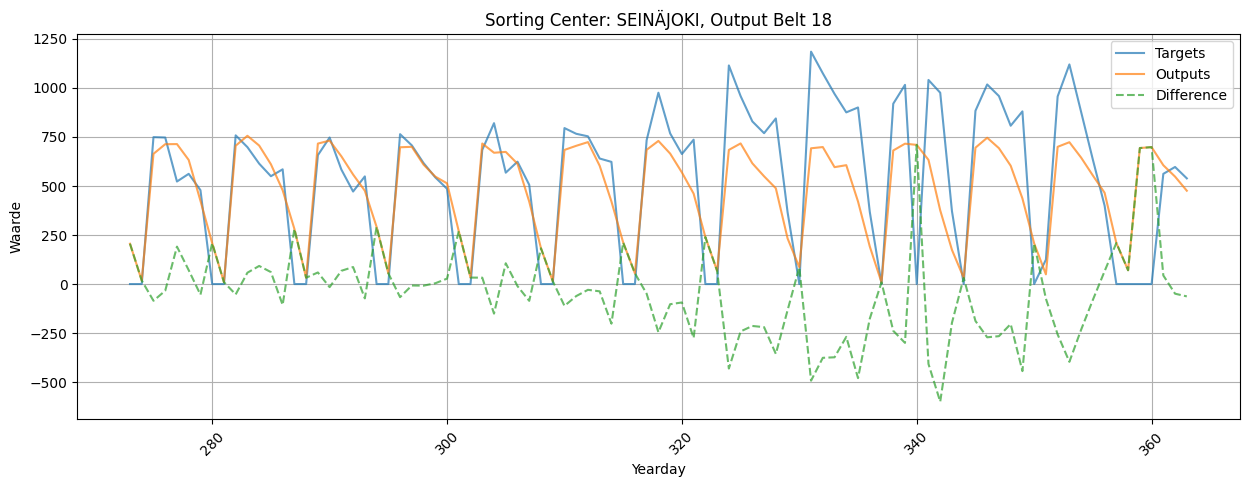

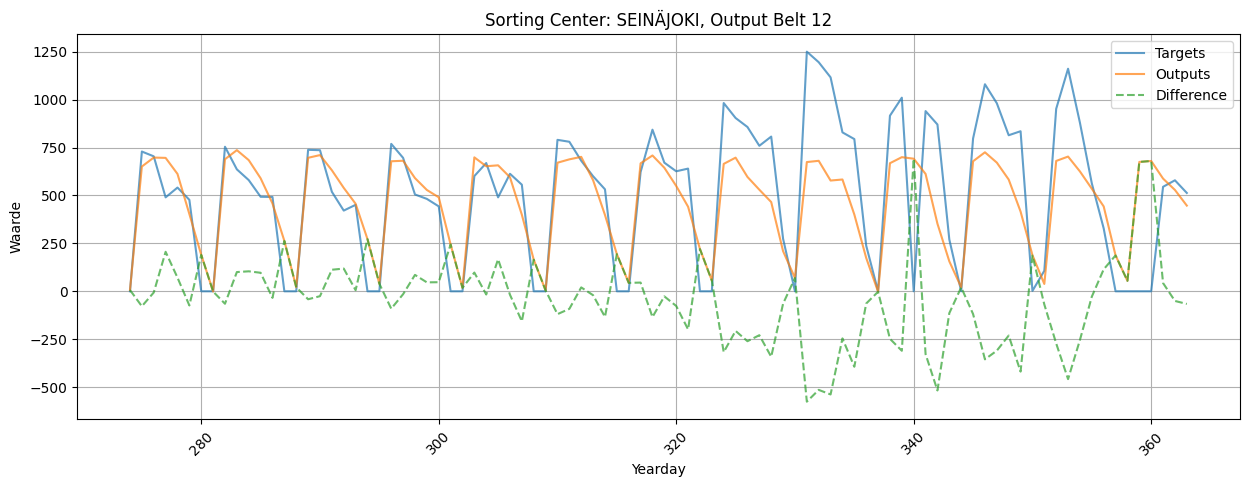

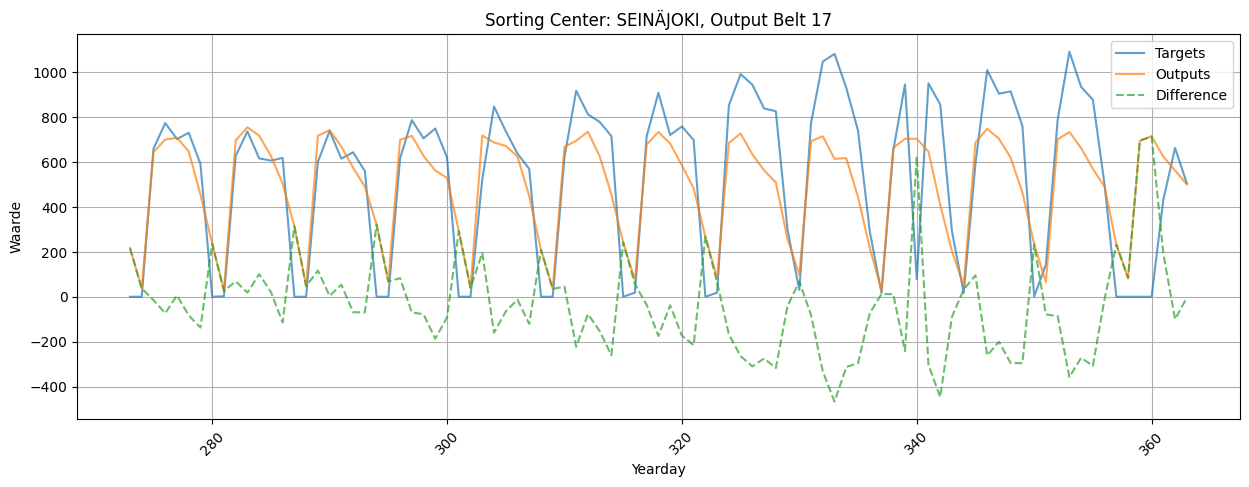

Plotting for Sorting Center: TAMPERE


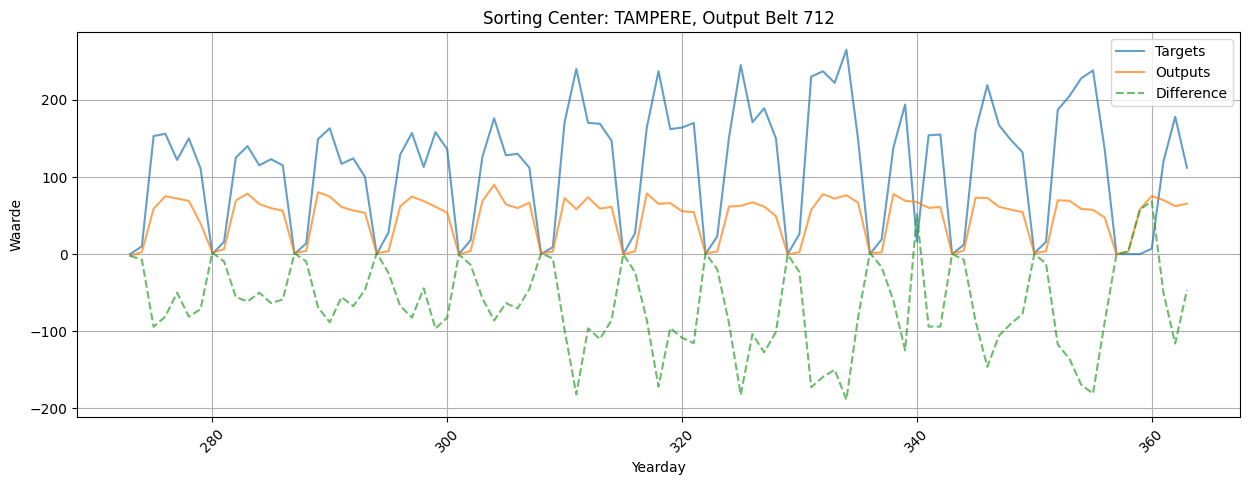

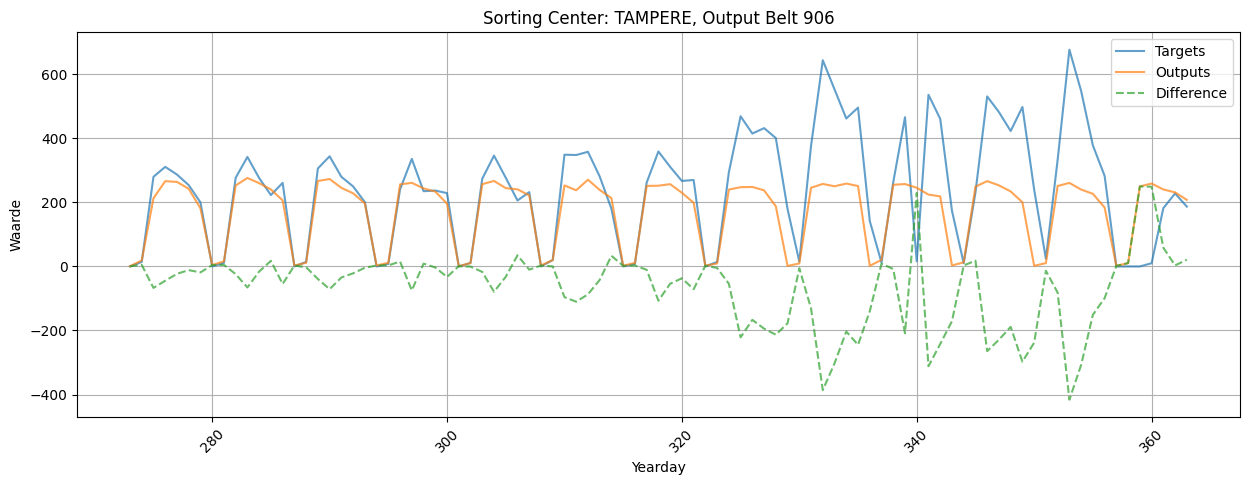

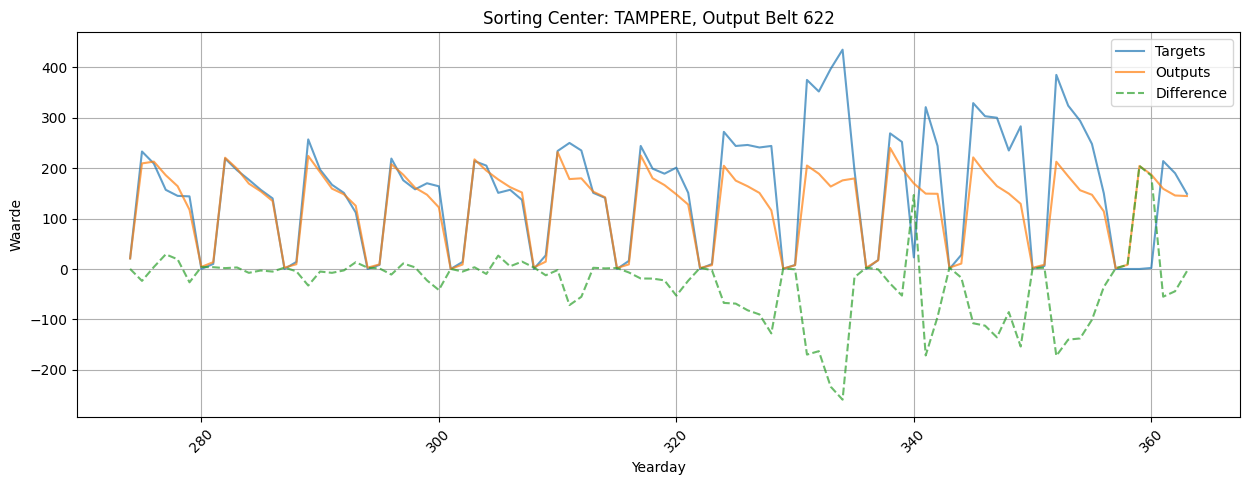

Plotting for Sorting Center: VANTAA


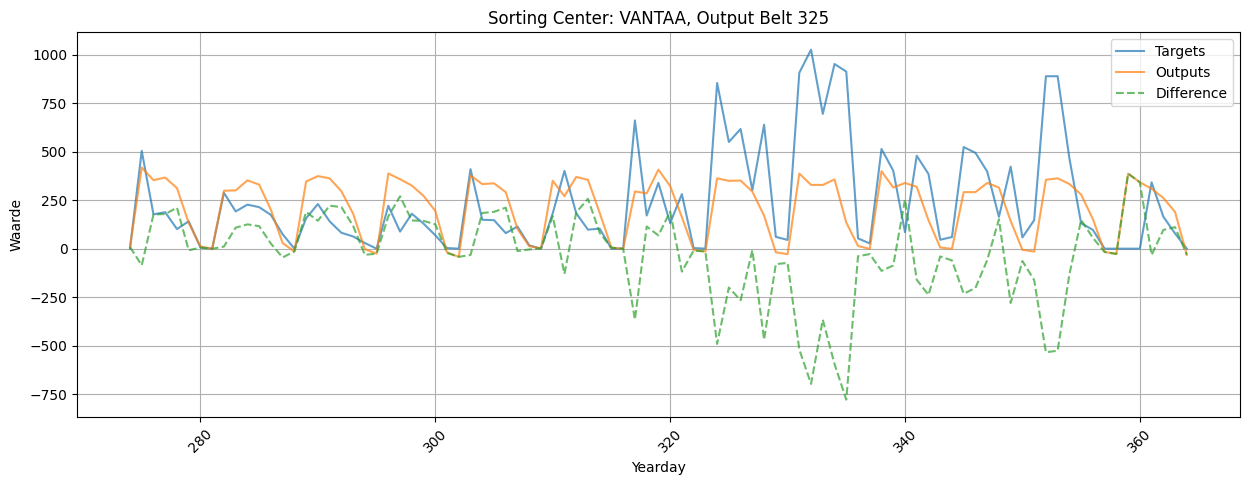

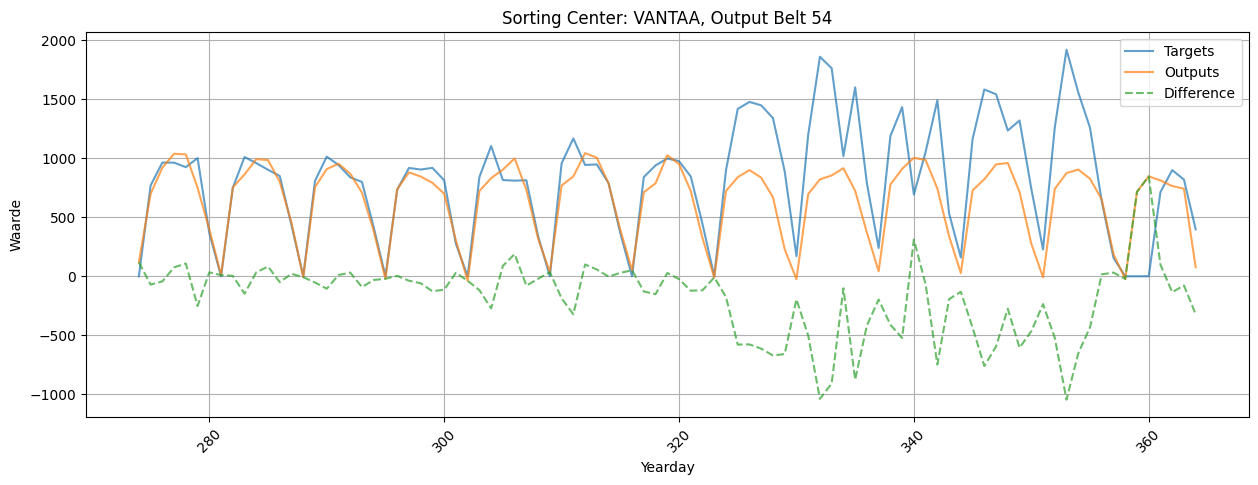

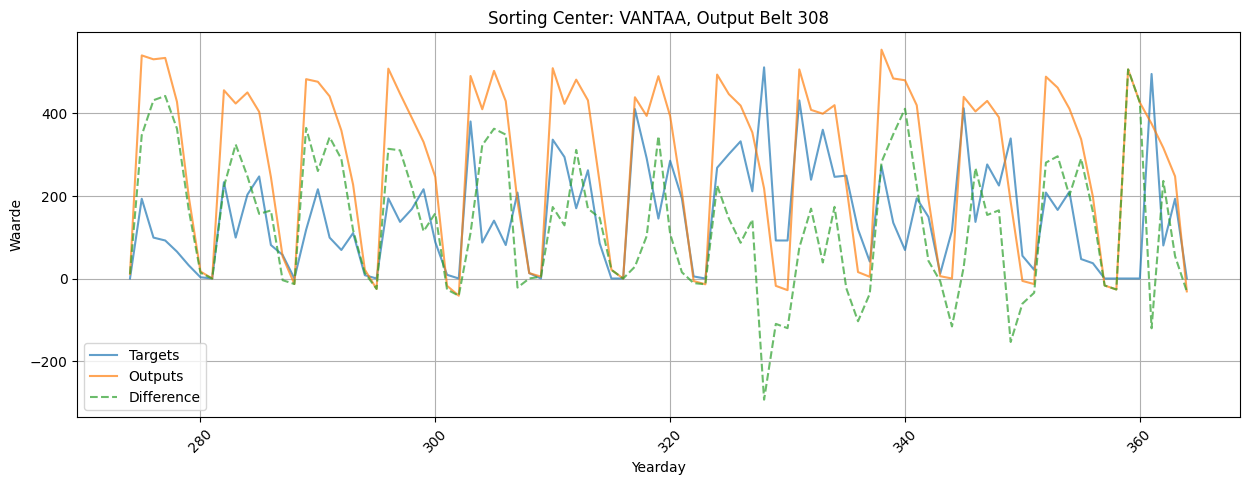

In [30]:
# Specifiek plotten voor VANTAA en belt 109
# plot_for_all_centers(trained_models, loaders, belts_per_center=belts_per_center, specific_center="VANTAA", specific_belt=109)

# Willekeurig 5 belts plotten voor elk center
plot_for_all_centers(trained_models, loaders, belts_per_center=belts_per_center, random_belts_count=3)

# Multi warehouse model 
## Multi-Warehouse Model Overview

The multi-warehouse model operates as follows:

1. **Sorting Center Selection**: It begins by filtering out any sorting centers that are not needed, allowing for flexible configuration based on specific warehouses of interest.

2. **One-Hot Encoding**: Each output belt is one-hot encoded as a unique combination of the output belt and sorting center. This encoding captures the distinct behavior of each belt at each center, ensuring the model can differentiate between them even if belts share the same ID across different centers.

3. **Model Execution**: Beyond these modifications, the rest of the code operates the same way as in the previous single-warehouse model, handling data processing, training, and prediction consistently.

This setup enables the model to learn and make predictions across multiple warehouses while preserving the unique characteristics of each belt-center combination.


In [19]:
df = df_o

In [20]:
df

sorting_center_name event_type scanning_date  output_belt  \
16791                VANTAA        LAJ    2023-01-02            1   
16792                VANTAA        LAJ    2023-01-02           10   
16793                VANTAA        LAJ    2023-01-02           10   
16794                VANTAA        LAJ    2023-01-02           10   
16795                VANTAA        LAJ    2023-01-02           10   
...                     ...        ...           ...          ...   
8789785                OULU        LAJ    2023-12-27            0   
8789786                OULU        LAJ    2023-12-27            0   
8789787                OULU        LAJ    2023-12-28            0   
8789788                OULU        LAJ    2023-12-28            0   
8789789                OULU        LAJ    2023-12-29            0   

         no_of_events  day  month  weekday  week  week_of_month  yearday  
16791              13    2      1        1     1              1        2  
16792               4    2      1        1     1              1        2  
16793               2    2      1        1     1              1        2  
16794               7    2      1        1     1              1        2  
16795               3    2      1        1     1              1        2  
...               ...  ...    ...      ...   ...            ...      ...  
8789785           105   27     12        3    52              4      361  
8789786           707   27     12        3    52              4      361  
8789787             3   28     12        4    52              4      362  
8789788           792   28     12        4    52              4      362  
8789789           669   29     12        5    52              5      363  

[7450939 rows x 11 columns]

In [21]:
# Bewaar de originele output_belt kolom
df['old_output_belt'] = df['output_belt']

# Creëer een unieke ID op basis van de combinatie van sorting_center_name en output_belt
df['output_belt'] = (df['sorting_center_name'] + '_' + df['output_belt'].astype(str)).astype('category').cat.codes

def remove_sorting_centers(df, centers_to_remove):
    return df[~df['sorting_center_name'].isin(centers_to_remove)].reset_index(drop=True)

# Remove the 'VANTAA' sorting center
centers_to_remove = ['VANTAA']
df = remove_sorting_centers(df, centers_to_remove)

# Group the data by sorting center, scanning date, and output belt, then merge with other time-related columns
df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index=False)['no_of_events'].sum() \
    .merge(df[['sorting_center_name', 'scanning_date', 'day', 'month', 'weekday', 'week', 'week_of_month', 'yearday']].drop_duplicates(), 
           on=['sorting_center_name', 'scanning_date'], how='left')


In [22]:
"Function to fill missing event data by generating all possible dates, sorting centers, and output belts, filling missing combinations with zero events."
def fill_missing_events(df):
    all_dates = pd.date_range(start=df['scanning_date'].min(), end=df['scanning_date'].max())
    all_combinations = []

    "Generate all combinations of sorting centers and output belts for all dates."
    for sorting_center in df['sorting_center_name'].unique():
        output_belts = df[df['sorting_center_name'] == sorting_center]['output_belt'].unique()
        combinations = pd.MultiIndex.from_product([[sorting_center], all_dates, output_belts], 
                                                  names=['sorting_center_name', 'scanning_date', 'output_belt'])
        all_combinations.append(pd.DataFrame(index=combinations).reset_index())  

    "Merge generated combinations with original data, filling missing events with 0."
    all_combinations_df = pd.concat(all_combinations, ignore_index=True)
    df_filled = pd.merge(all_combinations_df, df, on=['sorting_center_name', 'scanning_date', 'output_belt'], how='left')
    
    df_filled['no_of_events'] = df_filled['no_of_events'].fillna(0)  
    "Add time-related features to enhance dataset information."
    df_filled['day'] = df_filled['scanning_date'].dt.day
    df_filled['month'] = df_filled['scanning_date'].dt.month
    df_filled['weekday'] = df_filled['scanning_date'].dt.dayofweek + 1
    df_filled['week'] = df_filled['scanning_date'].dt.isocalendar().week
    df_filled['week_of_month'] = (df_filled['day'] - 1) // 7 + 1
    df_filled['yearday'] = df_filled['scanning_date'].dt.dayofyear  

    return df_filled

df = fill_missing_events(df)

In [23]:
"Sort data chronologically and reset the index to maintain order."
df = df.sort_values(by='scanning_date')
df = df.reset_index(drop=True)

In [24]:
"Create new columns 'mult' and 'sum' to capture relationships between day, weekday, and week_of_month."
df['mult'] = df['day'] * df['weekday'] * df['week_of_month']
df['sum'] = df['day'] + df['weekday'] + df['week_of_month']
    
# Maak one-hot encoded kolommen zonder de originele 'output_belt' kolom te verwijderen
one_hot_belt = pd.get_dummies(df['output_belt'], prefix='output_belt').astype(int)
df = pd.concat([df, one_hot_belt], axis=1)
df

sorting_center_name scanning_date  output_belt  no_of_events  day  \
0                   KUOPIO    2023-01-01            0           0.0    1   
1                  TAMPERE    2023-01-01          395           2.0    1   
2                  TAMPERE    2023-01-01          394           4.0    1   
3                  TAMPERE    2023-01-01          393           5.0    1   
4                  TAMPERE    2023-01-01          392           3.0    1   
...                    ...           ...          ...           ...  ...   
187303              KUOPIO    2023-12-29          107          48.0   29   
187304              KUOPIO    2023-12-29          108          23.0   29   
187305              KUOPIO    2023-12-29          109          43.0   29   
187306              KUOPIO    2023-12-29           57          23.0   29   
187307             TAMPERE    2023-12-29          441           0.0   29   

        month  weekday  week  week_of_month  yearday  ...  output_belt_506  \
0           1        7    52              1        1  ...                0   
1           1        7    52              1        1  ...                0   
2           1        7    52              1        1  ...                0   
3           1        7    52              1        1  ...                0   
4           1        7    52              1        1  ...                0   
...       ...      ...   ...            ...      ...  ...              ...   
187303     12        5    52              5      363  ...                0   
187304     12        5    52              5      363  ...                0   
187305     12        5    52              5      363  ...                0   
187306     12        5    52              5      363  ...                0   
187307     12        5    52              5      363  ...                0   

        output_belt_507  output_belt_508  output_belt_509  output_belt_510  \
0                     0                0                0                0   
1                     0                0                0                0   
2                     0                0                0                0   
3                     0                0                0                0   
4                     0                0                0                0   
...                 ...              ...              ...              ...   
187303                0                0                0                0   
187304                0                0                0                0   
187305                0                0                0                0   
187306                0                0                0                0   
187307                0                0                0                0   

        output_belt_511  output_belt_512  output_belt_513  output_belt_514  \
0                     0                0                0                0   
1                     0                0                0                0   
2                     0                0                0                0   
3                     0                0                0                0   
4                     0                0                0                0   
...                 ...              ...              ...              ...   
187303                0                0                0                0   
187304                0                0                0                0   
187305                0                0                0                0   
187306                0                0                0                0   
187307                0                0                0                0   

        output_belt_515  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
187303                0  
187304                0  
187305                0  
187306                0

In [25]:
"Define a dataset class for structured use in PyTorch."
class EventDataset(Dataset):
    def __init__(self, df):

        self.data = df  
        one_hot_columns = [col for col in self.data.columns if col.startswith('output_belt_')]
        feature_columns = one_hot_columns + ['day', 'weekday', 'week_of_month', 'mult']
        self.inputs = torch.tensor(self.data[feature_columns].values.astype(int), dtype=torch.long)
        self.targets = torch.tensor(self.data['no_of_events'].values.astype(float), dtype=torch.float32)
        self.yearday = torch.tensor(self.data['yearday'].values.astype(int), dtype=torch.long)
        self.output_belt = torch.tensor(self.data['output_belt'].values.astype(int), dtype=torch.long)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.output_belt[idx], self.yearday[idx]

    def __len__(self):
        return len(self.data)

In [26]:
"Create dataloaders for train and test datasets with specified batch size and split method."
def create_dataloaders_for_df(df, test_size=0.25, batch_size=512, method='sequential'):
    train_df, test_df = split_dataset(df, method=method, test_size=test_size)
    train_loader = DataLoader(EventDataset(train_df), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(EventDataset(test_df), batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

"Function to split the dataset either sequentially or randomly based on the chosen method."
def split_dataset(df, method='sequential', test_size=0.25):
    if method == 'random':
        return train_test_split(df, test_size=test_size, random_state=42)
    else:  
        split_idx = int((1 - test_size) * len(df))
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        return train_df, test_df


"Initialize train and test loaders using the split dataset."
train_df, test_df = split_dataset(df, test_size=0.25, method='sequential')

train_loader = DataLoader(EventDataset(train_df), batch_size=512, shuffle=False)
test_loader = DataLoader(EventDataset(test_df), batch_size=512, shuffle=True)

train_inputs, train_targets, _, _ = next(iter(train_loader))
test_inputs, test_targets, _, _ = next(iter(test_loader))

# "Print sample input and target data for verification."
# print(f"Train Input: {train_inputs[0]}, Train Target: {train_targets[0].item()}")
# print(f"Test Input: {test_inputs[0]}, Test Target: {test_targets[0].item()}\n")

Epoch [1/100], Train Loss: 113.4279, Test Loss: 100.0328, MSE: 76899.8260, MAE: 192.9273, LR: 0.001000
Epoch [2/100], Train Loss: 80.8927, Test Loss: 81.4857, MSE: 66389.7854, MAE: 190.8177, LR: 0.001000
Epoch [3/100], Train Loss: 66.3262, Test Loss: 67.1804, MSE: 48859.7247, MAE: 143.6560, LR: 0.001000
Epoch [4/100], Train Loss: 61.8764, Test Loss: 70.3372, MSE: 46447.0744, MAE: 139.6953, LR: 0.001000
Epoch [5/100], Train Loss: 57.1323, Test Loss: 54.7121, MSE: 43526.0325, MAE: 130.5520, LR: 0.001000
Epoch [6/100], Train Loss: 54.9769, Test Loss: 53.0162, MSE: 40379.3468, MAE: 125.4958, LR: 0.001000
Epoch [7/100], Train Loss: 48.8122, Test Loss: 50.7156, MSE: 45456.7860, MAE: 137.8845, LR: 0.001000
Epoch [8/100], Train Loss: 47.1622, Test Loss: 58.0380, MSE: 62478.9406, MAE: 176.6617, LR: 0.001000
Epoch [9/100], Train Loss: 48.0297, Test Loss: 51.1227, MSE: 49240.6934, MAE: 147.9878, LR: 0.001000
Epoch [10/100], Train Loss: 46.6331, Test Loss: 48.2060, MSE: 36264.4341, MAE: 116.3536, 

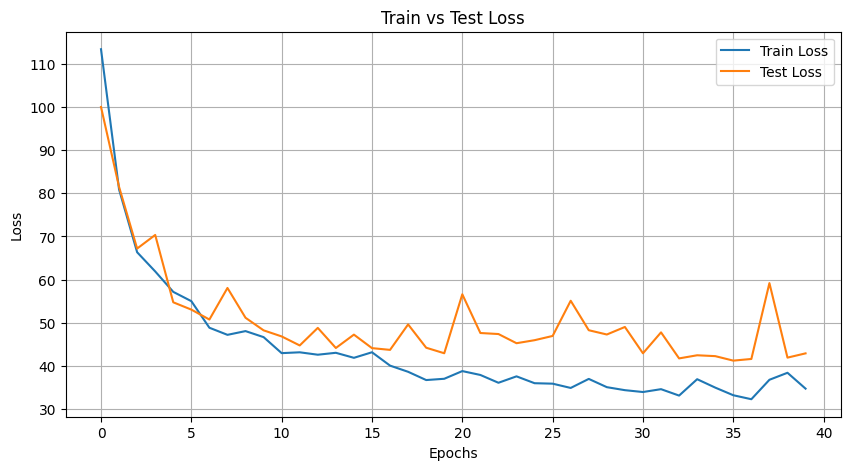

In [31]:
"Define a simple neural network model with skip connections for enhanced representation learning."
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*128)
        self.fc2 = nn.Linear(2*128, 2*128)
        self.fc3 = nn.Linear(2*128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

    def swish(self, x):
        return x * torch.sigmoid(x)

    def forward(self, x):
        x1 = self.swish(self.fc1(x))
        x2 = self.swish(self.fc2(x1)) + x1  
        x3 = self.swish(self.fc3(x2))
        x4 = self.swish(self.fc4(x3)) + x3  
        x5 = self.swish(self.fc5(x4))
        output = self.fc6(x5)
        return output

"Determine input dimensions based on training data and initialize the model and optimizer."
tau = 0.57  # Kies een waarde voor tau (0.5 is de mediaan)
input_dim = next(iter(train_loader))[0].shape[1]  
model = SimpleNN(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

"Train the model and capture train and test losses for tracking model performance."
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=20, min_delta=0.1)

"Plot the train and test losses for visualizing training progress."
plot_losses(train_losses, test_losses)


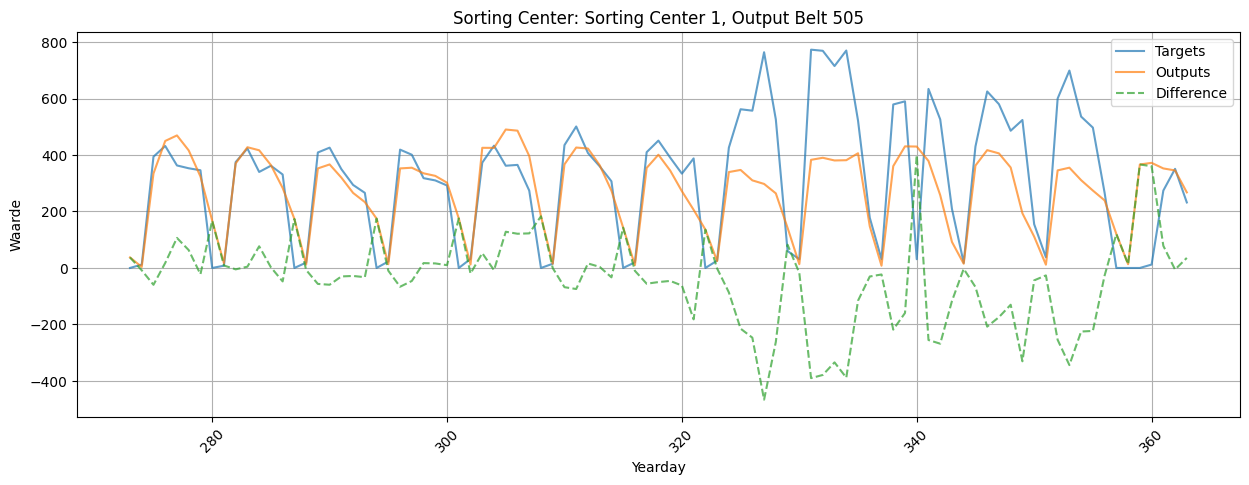

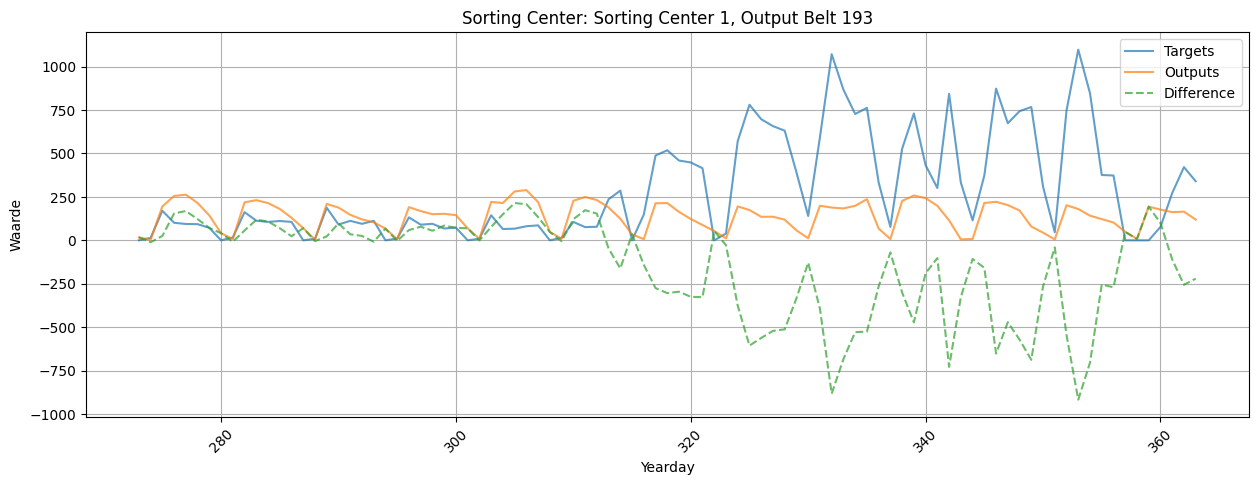

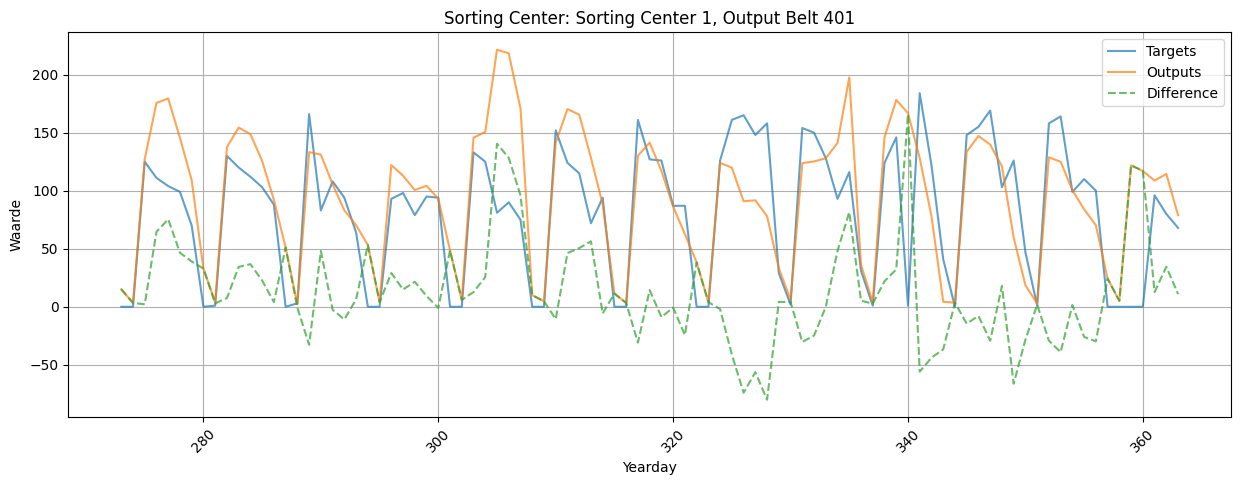

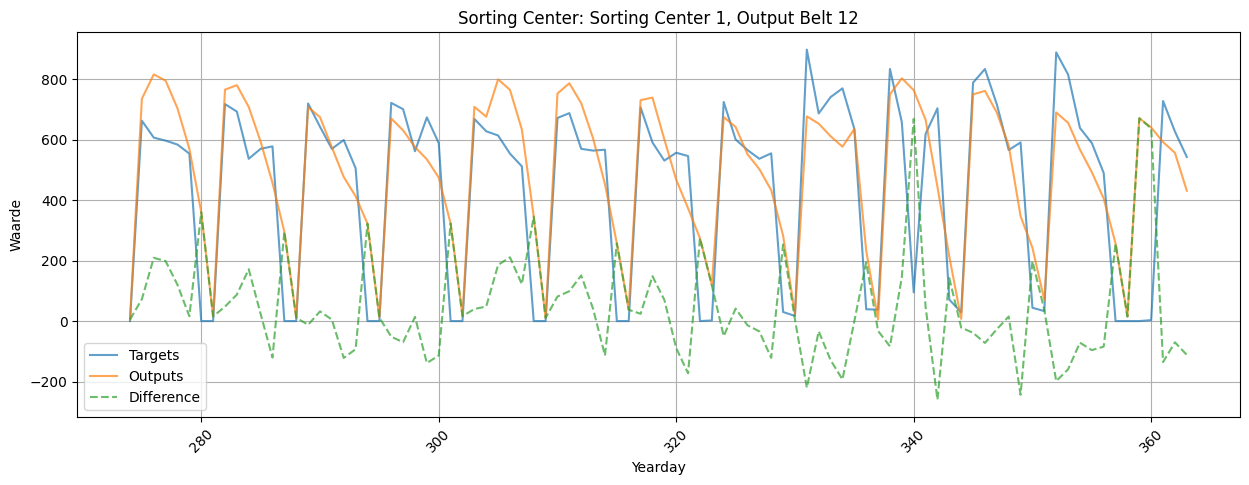

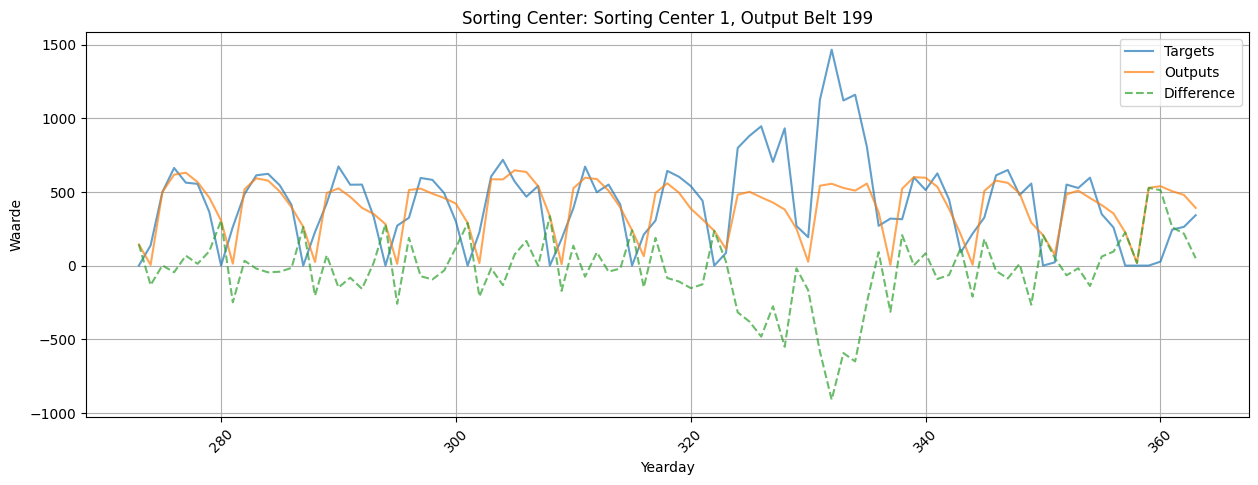

In [32]:

"Select unique belts for plotting output belt predictions on a single sorting center."
unique_belts = np.unique([belt for _, _, belts, _ in test_loader for belt in belts.numpy()])
selected_belts = np.random.choice(unique_belts, size=min(5, len(unique_belts)), replace=False)

"Plot prediction results for a specific sorting center using the selected output belts."
plot_output_belts_for_center(model, test_loader, "Sorting Center 1", selected_belts)


## Model Performance Summary

### Accuracy and Prediction Quality
- **General Accuracy**: The model's predictions (`Outputs`) align reasonably with actual values (`Targets`), indicating it captures general order patterns.
- **Seasonal Trend (December)**: Higher order volumes in December are visible, but the model doesn’t fully account for this, likely due to lack of training on holiday data.

### Multi-Warehouse Performance
- **Lower Accuracy**: Performance drops for multiple warehouses, with predictions deviating more from actual values. This suggests the model could benefit from specific multi-location training.

### Practical Advantages
- **Efficiency**: The model is lightweight, making it efficient in terms of computational resources—ideal for real-time applications.
- **Scalability**: Works across different warehouses with minimal modifications.
- **Adaptability**: Can be easily updated with seasonal data to improve robustness.

Overall, while the model could improve for peak periods and multi-warehouse setups, it balances accuracy with efficiency, making it a practical choice for order prediction.
